In [35]:
import numpy as np
import scipy
import crossprob
from numpy import linalg as LA
import math
from tqdm import tqdm
from dataclasses import dataclass
import torch
from scipy.stats import norm

import matplotlib.pyplot as plt

import var_control.bounds as bounds
import optuna
from var_control.optimization import *
from datetime import datetime
import logging
from src.bounds import integrate_smooth_delta
from src.bounds import integrate_smooth_delta_upper
from src.bounds import get_upper_from_lower

In [36]:
@dataclass
class Args:
    n: int
    beta_min: float
    beta_max: float
    metric: str
    noise_init: bool = True
    noise_level: float = 0.01
    device: str = "cuda:0"
    stage_1_iter: int = 100000
    print_every: int = 100
    seed: int = 1
    save_results: bool = False
    delta: float = 0.05
    max_iter: int = 5000
    lr: float = 1e-5
    lamb: float = 5e-5
    seed_size: int = 128
    num_layers: int = 1
    hidden_dim: int = 64
    early_stop: int = 3
    g_name: str = "female_black"
    dataset: str = "civil_comments"

In [37]:
def validate(net, S, X, X_torch, args):
    net.eval()
    B_0 = net(S)
    b_exp = torch.exp(B_0)
    L_final = (torch.cumsum(b_exp, 0)/(torch.sum(b_exp)+1)).detach().cpu().numpy().astype("float64")

    L_post = None
    denom = 1000000
    for j in range(denom):
        corr = j/denom
        L_corr = np.clip(L_final-corr, 0.0, 1.0)
        c = 1-args.delta-crossprob.ecdf2(L_corr, np.ones(args.n), True)

        if c < 0.0:
            L_post = L_corr
            # print(("correction:", corr, "| constraint for L_post:", c))
            break

        
    if args.metric != "delta" and args.metric != "dual":
        L_post_risk = quantile_based_loss(
            X, 
            torch.Tensor(L_post).cuda(), 
            beta_min=args.beta_min, 
            beta_max=args.beta_max, 
            weighted=args.weighted_loss
        )[0].item()
    elif args.metric == "dual":
        L_post_risk_1 = quantile_based_loss(
            X_torch, 
            torch.Tensor(L_post).cuda(), 
            beta_min=0.0, 
            beta_max=1.0, 
            weighted=args.weighted_loss
        )[0].item()
        L_post_risk_2 = integrate_smooth_delta(
            np.expand_dims(X[:-1], 0), 
            L_post, 
            beta_min=args.beta_min, 
            beta_max=args.beta_max
        )[0].item()
        L_post_risk = L_post_risk_1 + L_post_risk_2
    else:
        L_post_risk = integrate_smooth_delta(
            np.expand_dims(X[:-1], 0), 
            L_post, 
            beta_min=args.beta_min, 
            beta_max=args.beta_max
        )[0].item()

    return L_post_risk, L_post


def run_exp(args):

    bound_save_root = "../data/civil_comments/bound_samples/{}_{}.pt".format(args.g_name, args.n)
    bound_save_root

    model_name = "g_{}_n_{}_layers_{}_seed_size_{}_hidden_{}".format(
        args.g_name,
        args.n, 
        args.num_layers, 
        args.seed_size, 
        args.hidden_dim
    )
    print(model_name)

    def phi_delta(p):
        a = 0.1
        beta = 0.5
        return norm.pdf(p, beta, ((a**2)/2))
        # return (1/(a*np.pi))*np.exp(-( (p-beta)**2 / a**2 ))

    def phi(p):

        if args.metric=="mean":
            res = phi_mean(p)
        elif args.metric=="cvar":
            res = phi_cvar(args.beta_min, p)
        elif args.metric == "var_int":
            res = phi_intvar(args.beta_min, args.beta_max, p)
        elif args.metric=="p":
            res = phi_p(p)
        elif args.metric=="delta":
            res = phi_delta(p)
        elif args.metric=="dual":
            res = phi_mean(p) + phi_delta(p)
        else: 
            raise ValueError
        return res

    args.weighted_loss = (args.metric == "p")

    torch.manual_seed(args.seed)
    np.random.seed(args.seed)


    X_full = torch.load(bound_save_root)
    X = np.sort(X_full[:args.n], axis=-1)
    X = np.concatenate([X, [1.0]])
    X = X.astype('float128')
    X_torch = torch.Tensor(X[:-1].reshape(1,-1).astype('float64')).cuda()
    
    cons_factor = 0.1

    if args.metric == "delta":

        L_BJ = bounds.berk_jones_two_sided(args.n, args.delta, 0.0, 1.0)
        L_BJ_risk = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L_BJ, beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
        print(("BJ Risk", L_BJ_risk))

        L_BJ_cons = bounds.berk_jones_two_sided(args.n, cons_factor*args.delta, 0.0, 1.0)
        L_BJ_cons_risk = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L_BJ_cons, beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
        print(("Cons. BJ Risk", L_BJ_cons_risk))
        
        L_BJ_trunc_risk = None
        
    elif args.metric == "dual":
        
        L_BJ = bounds.berk_jones_two_sided(args.n, args.delta, 0.0, 1.0)
        L_BJ_mean_risk = quantile_based_loss(X_torch, torch.Tensor(L_BJ).cuda(), beta_min=0.0, beta_max=1.0, weighted=args.weighted_loss)[0].item()
        L_BJ_delta_risk = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L_BJ, beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
        print(("BJ Risk", L_BJ_mean_risk, L_BJ_delta_risk, L_BJ_mean_risk+L_BJ_delta_risk))

        L_BJ_cons = bounds.berk_jones_two_sided(args.n, cons_factor*args.delta, 0.0, 1.0)
        L_BJ_cons_mean_risk = quantile_based_loss(X_torch, torch.Tensor(L_BJ_cons).cuda(), beta_min=0.0, beta_max=1.0, weighted=args.weighted_loss)[0].item()
        L_BJ_cons_delta_risk = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L_BJ_cons, beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
        print(("Cons. BJ Risk", L_BJ_cons_mean_risk, L_BJ_cons_delta_risk, L_BJ_cons_mean_risk+L_BJ_cons_delta_risk))

    else:

        L_BJ = bounds.berk_jones_two_sided(args.n, args.delta, 0.0, 1.0)
        L_BJ_risk = quantile_based_loss(X_torch, torch.Tensor(L_BJ).cuda(), beta_min=args.beta_min, beta_max=args.beta_max, weighted=args.weighted_loss)[0].item()
        print(("BJ Risk", L_BJ_risk))
        
        L_BJ_trunc = bounds.berk_jones_two_sided(args.n, args.delta, args.beta_min, args.beta_max)
        L_BJ_trunc_risk = quantile_based_loss(X_torch, torch.Tensor(L_BJ_trunc).cuda(), beta_min=args.beta_min, beta_max=args.beta_max, weighted=args.weighted_loss)[0].item()
        print(("Trunc. BJ Risk", L_BJ_trunc_risk))

        L_BJ_cons = bounds.berk_jones_two_sided(args.n, cons_factor*args.delta, 0.0, 1.0)
        L_BJ_cons_risk = quantile_based_loss(X_torch, torch.Tensor(L_BJ_cons).cuda(), beta_min=args.beta_min, beta_max=args.beta_max, weighted=args.weighted_loss)[0].item()
        print(("Cons. BJ Risk", L_BJ_cons_risk))
        
    B_int = np.ones(args.n)
    B_int = B_int.astype('float128')

    S = torch.normal(0, 0.1, size=(args.n, args.seed_size)).cuda()

    net_path = "../models/seed_net/{}/{}.pt".format(args.dataset, model_name)
    print("net path", net_path)

    best_overall_score = float("INF")
    best_overall_bound = None
    best_params = None

    # for lr in [1e-4, 5e-5, 1e-5, 5e-6, 1e-6]:
    #     for lamb in [5e-4, 1e-4, 5e-5, 1e-5, 5e-6]:

    for lr in [5e-5]:
        for lamb in [5e-5]:

            print("\nNEW TRIAL")
            print("lr", lr)
            print("lamb", lamb)

            best_run_bound = None
            args.lr = lr
            args.lamb = lamb

            try:
                net = torch.load(net_path)
                optimizer = torch.optim.Adam(
                    net.parameters(),
                    args.lr,
                )

            except:

                net = SeedNet(input_dim=args.seed_size, hidden_dim=args.hidden_dim, num_layers=1)
                net.to("cuda")
                optimizer = torch.optim.Adam(
                    net.parameters(),
                    args.lr,
                )

                loss_fn = nn.MSELoss()  # mean square error
                losses = []

                n_epoch = args.stage_1_iter
                for epoch in tqdm(range(n_epoch)):

                    net.train()
                    optimizer.zero_grad()

                    B_0 = net(S)
                    b_exp = torch.exp(B_0)
                    L_0 = torch.cumsum(b_exp, 0)/(torch.sum(b_exp)+1)

                    loss = loss_fn(L_0, torch.Tensor(L_BJ_cons).to(args.device))
                    # backward pass
                    optimizer.zero_grad()
                    losses.append(loss.item())
                    loss.backward()
                    # update weights
                    optimizer.step()

                plt.plot(np.arange(n_epoch), losses)
                plt.show()
                torch.save(net, net_path)

            net.eval()
            B_0 = net(S)
            b_exp = torch.exp(B_0)
            L_0 = torch.cumsum(b_exp, 0)/(torch.sum(b_exp)+1)

            c_0 = 1-args.delta-crossprob.ecdf2(L_0.detach().cpu().numpy().astype("float64"), np.ones(args.n), True)
            print("c_0", c_0)

            best_score = 100.0

            since_best = 0

            for epoch in range(args.max_iter):

                net.train()
                optimizer.zero_grad()

                B_0 = net(S)
                b_exp = torch.exp(B_0)
                L = torch.cumsum(b_exp, 0)/(torch.sum(b_exp)+1)

                for i in range(args.n-1):
                    if L[i] > L[i+1]:
                        print(("\nNon-increasing L", L, i, L[i:]))

                grad_f = loss_grad_exp(phi, X, B_0.detach().cpu().numpy())
                grad_g = 1-args.delta-softmax_grad_exp(B_0.detach().cpu().numpy())

                if (epoch) % args.print_every == 0:

                    if args.metric != "delta" and args.metric != "dual":
                        loss = quantile_based_loss(X_torch, L, beta_min=args.beta_min, beta_max=args.beta_max, weighted=args.weighted_loss)[0].item()
                        score, valid_bound = validate(net, S, X, X_torch, args)
                    elif args.metric == "dual":
                        mean_loss = quantile_based_loss(X_torch, L, beta_min=0.0, beta_max=1.0, weighted=args.weighted_loss)[0].item()
                        delta_loss = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L.detach().cpu().numpy().astype("float64"), beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
                        loss = mean_loss+delta_loss
                        score, valid_bound = validate(net, S, X, X_torch, args)
                    else:
                        loss = integrate_smooth_delta(np.expand_dims(X[:-1], 0), L.detach().cpu().numpy().astype("float64"), beta_min=args.beta_min, beta_max=args.beta_max)[0].item()
                        score, valid_bound = validate(net, S, X, X_torch, args)
                    constraint = 1-args.delta-crossprob.ecdf2(L.detach().cpu().numpy().astype("float64"), np.ones(args.n), True)

                    print((epoch, "| loss", loss, "constraint", constraint, "Optimized Bound Risk", score))
                    if score <= best_score:
                        best_score = score
                        best_run_bound = valid_bound
                        since_best = 0
                    else:
                        since_best += 1

                b_exp.backward(torch.Tensor(grad_f+args.lamb*grad_g).cuda())
                optimizer.step()

                if since_best >= args.early_stop:
                    break

            if args.metric == "delta":
                score, L_final = validate(net, S, X, X_torch, args)
            else:
                score, L_final = validate(net, S, X, X_torch, args)
            print((epoch, "| loss", loss, "constraint", constraint, "Optimized Bound Risk", score))

            c_final = 1-args.delta-crossprob.ecdf2(L_final, np.ones(args.n), True)
            print("final constraint", c_final)

            # best_score = min(best_score, score)

            if score <= best_score:
                best_score = score
                best_run_bound = L_final

            print(("best score:", best_score))

            if best_score < best_overall_score:
                print("New Best Run")
                best_overall_score = best_score
                best_overall_bound = best_run_bound
                best_params = {"lr": args.lr, "lamb": args.lamb}
                
    if args.metric != "dual":
        L_best_risk = quantile_based_loss(
            X_torch, 
            torch.Tensor(best_overall_bound).cuda(), 
            beta_min=args.beta_min, 
            beta_max=args.beta_max, 
            weighted=args.weighted_loss
        )[0].item()
    else:
        L_best_risk = integrate_smooth_delta(
            np.expand_dims(X[:-1], 0), 
            best_overall_bound, 
            beta_min=args.beta_min, 
            beta_max=args.beta_max
        )[0].item()
    
    X_full_sorted = torch.sort(X_full, axis=-1)[0]
    full_int = torch.arange(1, X_full.shape[0] + 1) / X_full.shape[0]

    if args.metric != "dual":
        emp_risk = quantile_based_loss(
            X_full_sorted.view(1,-1).cuda(), 
            full_int.cuda(), 
            beta_min=args.beta_min, 
            beta_max=args.beta_max, 
            weighted=args.weighted_loss
        )[0].item()
    else:
        emp_risk = integrate_smooth_delta(
            np.expand_dims(X_full, 0), 
            np.array(full_int), 
            beta_min=args.beta_min, 
            beta_max=args.beta_max
        )[0].item()

    plt.plot(full_int, X_full_sorted, label="$F_{emp}$")
    plt.plot(torch.Tensor(best_overall_bound), X_torch.squeeze(0).cpu(), label="$G_{opt}$")
    plt.plot(torch.tensor(L_BJ), X_torch.squeeze(0).cpu(), label="$G_{BJ}$")
    plt.legend()
    plt.title(args.metric)
    plt.xlabel(r'$\beta$')
    plt.ylabel("loss")
    plt_save_path = "../plots/opt_training/g_{}_n_{}.png".format(args.g_name, args.n)
    plt.savefig(plt_save_path, bbox_inches="tight")
    plt.show()

    print()
    print("Computing Target risk:", args.metric)
    print("Empirical risk:", emp_risk)
    print("G_opt:", L_best_risk, " | G_bj:", L_BJ_delta_risk)
    
    print()
    print("Constraint values")
    c_best = 1-args.delta-crossprob.ecdf2(best_overall_bound, np.ones(args.n), True)
    c_BJ = 1-args.delta-crossprob.ecdf2(L_BJ, np.ones(args.n), True)
    print("final constraint", c_best, " | BJ constraint", c_BJ)
        
    mean_risk_best = quantile_based_loss(
        X_torch, 
        torch.Tensor(best_overall_bound).cuda(), 
        beta_min=0.0, 
        beta_max=1.0, 
        weighted=args.weighted_loss
    )[0].item()
    mean_risk_L_bj = quantile_based_loss(
        X_torch, 
        torch.Tensor(L_BJ).cuda(), 
        beta_min=0.0, 
        beta_max=1.0, 
        weighted=args.weighted_loss
    )[0].item()
        
    print()
    print("Mean guarantees")
    print("G_opt:", mean_risk_best, " | G_bj:", mean_risk_L_bj)
    
    bound_save_root = "../data/civil_comments/opt_bounds/{}_{}.pt".format(args.g_name, args.n)
    torch.save(torch.Tensor(best_overall_bound), bound_save_root)


Args(n=100, beta_min=0.0, beta_max=1.0, metric='dual', noise_init=True, noise_level=0.01, device='cuda:0', stage_1_iter=100000, print_every=25, seed=2, save_results=False, delta=0.00025, max_iter=5000, lr=1e-05, lamb=5e-05, seed_size=32, num_layers=3, hidden_dim=64, early_stop=3, g_name='male_black', dataset='civil_comments')

g_male_black_n_100_layers_3_seed_size_32_hidden_64
('BJ Risk', 0.4241182804107666, 0.07548978419025930971, 0.49960806460102591127)
('Cons. BJ Risk', 0.44998329877853394, 0.1337022261985967059, 0.58368552497713064144)
net path ../models/seed_net/civil_comments/g_male_black_n_100_layers_3_seed_size_32_hidden_64.pt

NEW TRIAL
lr 5e-05
lamb 5e-05
c_0 0.03832152360531549
(0, '| loss', 0.53997561150804925043, 'constraint', 0.03832152360531549, 'Optimized Bound Risk', 0.5421643691828096699)
(25, '| loss', 0.5324821164280365718, 'constraint', 0.040450896807080805, 'Optimized Bound Risk', 0.53437493496410144104)
(50, '| loss', 0.5242474742711454169, 'constraint', 0.04275

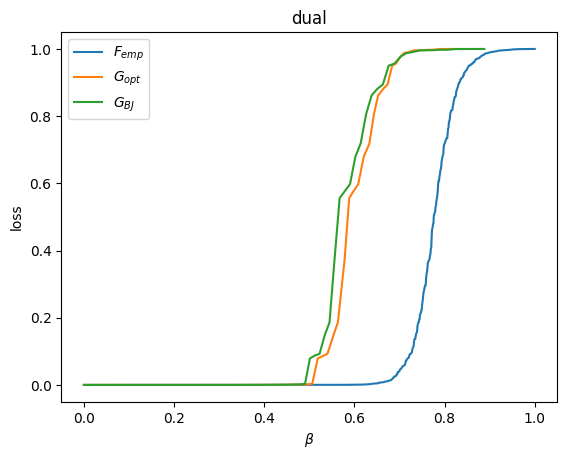


Computing Target risk: dual
Empirical risk: 1.8851685342210825e-05
G_opt: 0.016115994689401090346  | G_bj: 0.07548978419025930971

Constraint values
final constraint -3.147844096496044e-09  | BJ constraint 6.731837309814637e-12

Mean guarantees
G_opt: 0.40664732456207275  | G_bj: 0.4241182804107666

Args(n=100, beta_min=0.0, beta_max=1.0, metric='dual', noise_init=True, noise_level=0.01, device='cuda:0', stage_1_iter=100000, print_every=25, seed=2, save_results=False, delta=0.00025, max_iter=5000, lr=1e-05, lamb=5e-05, seed_size=32, num_layers=3, hidden_dim=64, early_stop=3, g_name='male_white', dataset='civil_comments')

g_male_white_n_100_layers_3_seed_size_32_hidden_64
('BJ Risk', 0.3727412223815918, 0.00441060380359122766, 0.37715182618518302453)
('Cons. BJ Risk', 0.3985905647277832, 0.015270881761556405348, 0.41386144648933960848)
net path ../models/seed_net/civil_comments/g_male_white_n_100_layers_3_seed_size_32_hidden_64.pt

NEW TRIAL
lr 5e-05
lamb 5e-05
c_0 0.03832152360531549

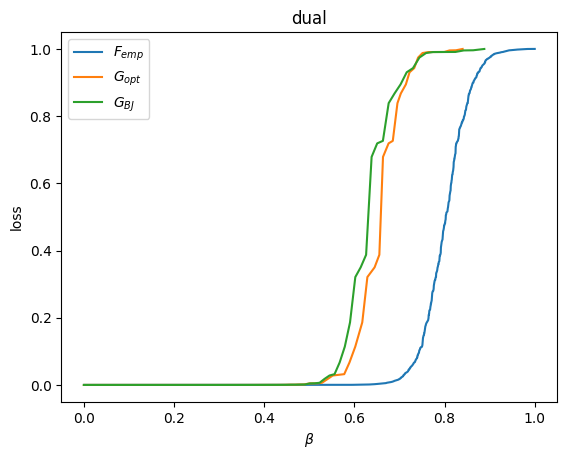


Computing Target risk: dual
Empirical risk: 1.2977282818893052e-05
G_opt: 0.004504066537093674331  | G_bj: 0.00441060380359122766

Constraint values
final constraint -6.1144409535529576e-09  | BJ constraint 6.731837309814637e-12

Mean guarantees
G_opt: 0.35013511776924133  | G_bj: 0.3727412223815918

Args(n=100, beta_min=0.0, beta_max=1.0, metric='dual', noise_init=True, noise_level=0.01, device='cuda:0', stage_1_iter=100000, print_every=25, seed=2, save_results=False, delta=0.00025, max_iter=5000, lr=1e-05, lamb=5e-05, seed_size=32, num_layers=3, hidden_dim=64, early_stop=3, g_name='female_black', dataset='civil_comments')

g_female_black_n_100_layers_3_seed_size_32_hidden_64
('BJ Risk', 0.2991980314254761, 0.0019700183973161292497, 0.30116804982279220346)
('Cons. BJ Risk', 0.3244973421096802, 0.005628496644955300076, 0.33012583875463547586)
net path ../models/seed_net/civil_comments/g_female_black_n_100_layers_3_seed_size_32_hidden_64.pt

NEW TRIAL
lr 5e-05
lamb 5e-05
c_0 0.03832152

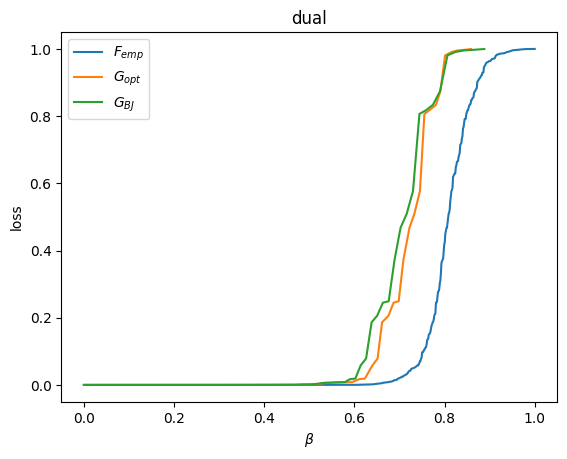


Computing Target risk: dual
Empirical risk: 1.4001012741211052e-05
G_opt: 0.001796833659766973413  | G_bj: 0.0019700183973161292497

Constraint values
final constraint -9.666677014408265e-09  | BJ constraint 6.731837309814637e-12

Mean guarantees
G_opt: 0.28279590606689453  | G_bj: 0.2991980314254761

Args(n=100, beta_min=0.0, beta_max=1.0, metric='dual', noise_init=True, noise_level=0.01, device='cuda:0', stage_1_iter=100000, print_every=25, seed=2, save_results=False, delta=0.00025, max_iter=5000, lr=1e-05, lamb=5e-05, seed_size=32, num_layers=3, hidden_dim=64, early_stop=3, g_name='female_white', dataset='civil_comments')

g_female_white_n_100_layers_3_seed_size_32_hidden_64
('BJ Risk', 0.2852136492729187, 0.0001851596997022704459, 0.28539880897262097161)
('Cons. BJ Risk', 0.31043189764022827, 0.00048706733763306630907, 0.31091896497786133778)
net path ../models/seed_net/civil_comments/g_female_white_n_100_layers_3_seed_size_32_hidden_64.pt

NEW TRIAL
lr 5e-05
lamb 5e-05
c_0 0.0383

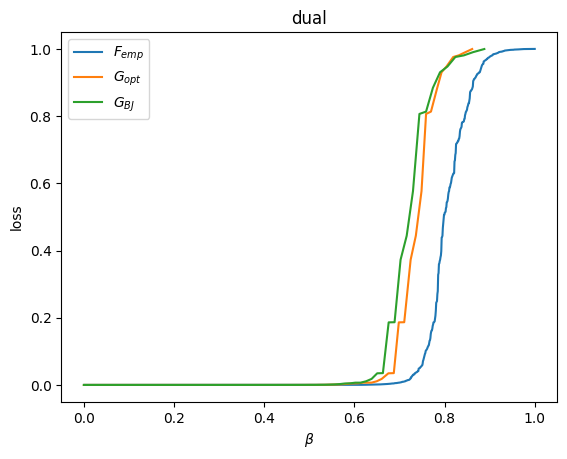


Computing Target risk: dual
Empirical risk: 7.886979740529122e-06
G_opt: 0.00018264361233837358158  | G_bj: 0.0001851596997022704459

Constraint values
final constraint -1.3546220034577061e-08  | BJ constraint 6.731837309814637e-12

Mean guarantees
G_opt: 0.2671896815299988  | G_bj: 0.2852136492729187


In [40]:
for g_name in ["male_black", "male_white", "female_black", "female_white"]:
    args = Args(
        beta_min = 0.0,
        beta_max = 1.0,
        metric = "dual",
        n = 100,
        max_iter = 5000,
        seed = 2,
        device = "cuda:0",
        print_every = 25,
        num_layers = 3,
        seed_size = 32,
        hidden_dim = 64,
        delta = 0.00025,
        g_name = g_name
    )
    print()
    print(args)
    print()
    run_exp(args)